In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

## For google colab

In [3]:
# !pip install -q kaggle
# from google.colab import files

# files.upload()

In [4]:
# !mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
# ! kaggle competitions download -c ocean-eddy-detection
# ! mkdir train
# ! unzip ocean-eddy-detection.zip -d train

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/SUP/4A/ocean-eddy-detection/'

Mounted at /content/drive


# Pre-processing

In [6]:
from torchvision import datasets, transforms

image_transforms_flips = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(1.0),
        transforms.RandomVerticalFlip(1.0),
    ]
)

image_transforms_blur = transforms.Compose(
    [
        transforms.GaussianBlur(7, sigma=(0.1, 3.0)),
    ]
)

Data without temperature.

In [7]:
class TrainDataset():
    def __init__(self, path):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(device)

        eddies_train = xr.open_dataset(path + 'eddies_train.nc')
        X_train = xr.open_dataset(path + 'OSSE_U_V_SLA_SST_train.nc')
        
        y = eddies_train.eddies.values
        
        X_verti = X_train.vomecrtyT.values
        X_hori = X_train.vozocrtxT.values
        X_SSH = X_train.sossheig.values
        # X_SST = X_train.votemper.values
        
        ##Transformation
        X = np.array([X_verti, X_hori, X_SSH])
        print(X.shape)
        X = X.transpose((1,0,2,3))
        
        y = np.nan_to_num(y, nan=3)
            
        #Enregistre les index correspondant aux bords
        edges_index = []
        for i in range(1,X.shape[2]-1):
            for j in range (1,X.shape[3]-1):
                if np.isnan(X[32, 2, i, j]):
                    if np.any(np.isnan(X[32, 2, i-1:i+2, j-1:j+2])!=True):
                        edges_index.append((i, j))  
        
        
        for img_index in tqdm(range(X.shape[0])):
            for index in edges_index:
                i, j = index
                X[img_index, :, i, j] = np.mean(X[img_index, :, i-1:i+2, j-1:j+2], axis=(1,2))

        
        X = np.nan_to_num(X, nan=0)
    
        ##Normalisation
        
        X = (X - np.min(X, axis=(0,2,3), keepdims=True))/( np.max(X, axis=(0,2,3), keepdims=True) - np.min(X, axis=(0,2,3), keepdims=True) )
        
        ##Augmentation 
        
        X = torch.tensor(X).to(device)
        y = torch.tensor(y, dtype=torch.long).reshape(y.shape[0],1, y.shape[1],y.shape[2]).to(device)
        data = torch.cat((X,y),dim=1)
        
        data_aug = image_transforms_flips(data)
        
        X_aug  = data_aug[:,:-1,:,:]
        
        X_aug = image_transforms_blur(X_aug)
        
        y_aug = data_aug[:,-1,:,:]
        
        self.X_train = torch.cat((X, X_aug), dim=0)
        self.y_train = torch.cat((y.reshape(y.shape[0], y.shape[2], y.shape[3]), y_aug), dim=0)
        
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [8]:
class TestDataSet():

    def __init__(self, path):
        self.X_test = xr.open_dataset(path + '/OSSE_U_V_SLA_SST_test.nc')
    
    def __len__(self):
        return len(self.X_test)
    
    def __getitem__(self, idx):
        return self.X_test[idx]


We split the set between one train set and one validation set.

In [9]:
from torch.utils.data import random_split

#path = 'ocean-eddy-detection/' # local
#path = 'train/' # if running on colab
dataset = TrainDataset(path)

trainDataSet, valDataSet = random_split(dataset, [0.8, 0.2])
trainDataLoader = DataLoader(trainDataSet, batch_size=4, shuffle=True)
valDataLoader = DataLoader(valDataSet, batch_size=2, shuffle=True)

print("The length of train data is:",len(trainDataSet))
print("The length of validation data is:",len(valDataSet))

cuda:0
(3, 284, 357, 717)


100%|██████████| 284/284 [00:18<00:00, 15.00it/s]


The length of train data is: 455
The length of validation data is: 113


In [10]:
iterator_data = iter(trainDataLoader)

torch.Size([4, 3, 357, 717])


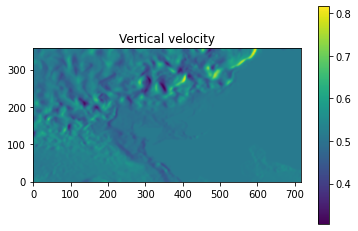

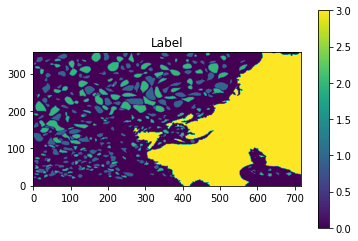

In [11]:
img, label = next(iterator_data)
print(img.shape)
plt.imshow(img[0][0].cpu(), origin='lower')
plt.colorbar()
plt.title('Vertical velocity')
plt.show()
plt.imshow(label[0].cpu(), origin='lower')
plt.colorbar()
plt.title('Label')
plt.show()

# Model

In [12]:
class Unet_3_blocks(nn.Module):
    """
    Our modified Unet :
    Use of padding to keep size of input in output easily.
    Use of batchnorm2d after Conv2d
    """
    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(3, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(128, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1)
        )


    def forward(self, x):

        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        xmiddle = self.middleU(x3)

        xup0_1 = torch.cat((x3,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x2,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x1,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        return xup3


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Adapted_loss(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss = nn.CrossEntropyLoss(weight=torch.Tensor([1/13, 6/13, 6/13]))
      
    def forward(self, prediction, target):
        mask = target!=3
        y = target[mask]
        ypred = prediction.transpose(0,1)
        ypred = ypred[:, mask].transpose(0,1)
        return self.loss(ypred, y)

# Training

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        #pred = pred.to(dtype=torch.float64)
    
        loss = loss_fn(pred, y.long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss and accuracy
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [15]:
from sklearn.metrics import f1_score

def f1_one_vs_all(prediction, target):
    pred = prediction.argmax(1).ravel()
    ytrue = target.ravel()

    F1=[]

    for k in range(3):
        class_k_true = ytrue==k
        class_k_pred = (pred==k)*(ytrue!=3)
        F1.append(f1_score(class_k_true,class_k_pred))

    return F1


In [16]:
def val_loop(dataloader, model, loss_fn, scheduler, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    a,b,c = 0,0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).to(device)
            test_loss += loss_fn(pred, y.long()).item()
            f = f1_one_vs_all(pred.cpu(), y.cpu())
            a += f[0]
            b += f[1]
            c += f[2]
    test_loss /= num_batches
    a/=size
    b/=size
    c/=size
    print(f"Test Error: \n F1: {(100*a):>0.2f}%, {(100*b):>0.2f}%, {(100*c):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    scheduler.step(test_loss)
    
    return test_loss

# Training for 3 blocks

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_3_blocks = Unet_3_blocks()
model_3_blocks = model_3_blocks.to(device)
loss_fn = Adapted_loss().to(device)
optimizer = torch.optim.Adam(model_3_blocks.parameters(), lr=1e-3)

cuda:0


In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [ ]:
epochs = 20

min_loss = np.inf

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainDataLoader, model_3_blocks, loss_fn, optimizer, device)
    test_loss = val_loop(valDataLoader, model_3_blocks, loss_fn, scheduler, device)
    if min_loss > test_loss:
        min_loss = test_loss
        torch.save(model_3_blocks, 'UNet_3_blocks_V2_reduceT.pth')
print("Done!")

# #Uncomment to save Model
torch.save(model_3_blocks, 'UNet_3_blocks_V2_final_training_reduceT.pth')

print("Model saved")

Epoch 1
-------------------------------
loss: 1.250238  [    0/  455]
loss: 1.031274  [   40/  455]
loss: 0.887591  [   80/  455]
loss: 0.854042  [  120/  455]
loss: 0.805046  [  160/  455]
loss: 0.794571  [  200/  455]
loss: 0.778475  [  240/  455]
loss: 0.766177  [  280/  455]
loss: 0.750093  [  320/  455]
loss: 0.730692  [  360/  455]
loss: 0.719203  [  400/  455]
loss: 0.691469  [  440/  455]
Test Error: 
 F1: 33.55%, 19.39%, 21.61%, Avg loss: 0.856351 

Epoch 2
-------------------------------
loss: 0.705386  [    0/  455]
loss: 0.730972  [   40/  455]
loss: 0.707755  [   80/  455]
loss: 0.698636  [  120/  455]
loss: 0.692334  [  160/  455]
loss: 0.674569  [  200/  455]
loss: 0.685446  [  240/  455]
loss: 0.687991  [  280/  455]
loss: 0.675359  [  320/  455]
loss: 0.667317  [  360/  455]
loss: 0.673053  [  400/  455]
loss: 0.667322  [  440/  455]
Test Error: 
 F1: 41.04%, 17.78%, 16.60%, Avg loss: 1.585652 

Epoch 3
-------------------------------
loss: 0.677709  [    0/  455]
loss

# Visualisation

In [ ]:
model = torch.load('UNet_3_blocks_V2_reduceT.pth', map_location=torch.device('cpu'))

In [ ]:
x_test, label_test = next(iter(valDataLoader))
print(label_test.shape)
x_test = x_test.to(device)[0]
pred = np.argmax(model(x_test.reshape(1,4,357,717)).softmax(dim=1).cpu().detach().numpy(), axis=1)[0]
mask = label_test[0]==3
pred[mask] = 3

In [ ]:
plt.imshow(label_test[0], origin='lower')
plt.colorbar()
plt.show()
plt.imshow(pred, origin='lower')
plt.colorbar()
plt.show()

## Confusion matrix

In [ ]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(pred, label_test[0])
plot_confusion_matrix(conf_matrix)